In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os

print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

import zipfile
with zipfile.ZipFile('../input/plates.zip', 'r') as zip_obj:
   # Extract all the contents of zip file in current directory
   zip_obj.extractall('/kaggle/working/')
    
print('After zip extraction:')
print(os.listdir("/kaggle/working/"))

data_root = '/kaggle/working/plates/'
print(os.listdir(data_root))

import shutil 
from tqdm import tqdm

train_dir = 'train'
val_dir = 'val'

class_names = ['cleaned', 'dirty']

for dir_name in [train_dir, val_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

for class_name in class_names:
    source_dir = os.path.join(data_root, 'train', class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        if i % 6 != 0:
            dest_dir = os.path.join(train_dir, class_name)             
        else:
            dest_dir = os.path.join(val_dir, class_name)
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))
        
!ls train

import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import time
import copy
import random
from PIL import Image


from torchvision import transforms, models
from torchvision.transforms import functional
from torch.utils.data import ConcatDataset
from matplotlib.animation import FuncAnimation
batch_size = 8

['sample_submission.csv', 'plates.zip']
After zip extraction:
['plates', '.virtual_documents', '__MACOSX']
['train', 'test', '.DS_Store']


100%|██████████| 21/21 [00:00<00:00, 3947.49it/s]


cleaned  dirty


In [14]:
def prepare_data_set(train_dir,val_dir,batch_size):
    
    list_of_train_datasets = []
    
    train_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])    
            
    train_dataset = torchvision.datasets.ImageFolder(train_dir,train_transforms)   
        
    list_of_train_datasets.append(train_dataset)
    print(len(train_dataset))
    
    for i in range(10):
        train_transforms = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])    
            
        train_dataset = torchvision.datasets.ImageFolder(train_dir,train_transforms)   
        
        list_of_train_datasets.append(train_dataset)
            
    train_dataset = ConcatDataset(list_of_train_datasets)
    
    val_transforms1 = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms1)
    
    train_dataloader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)
    val_dataloader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)
    
    return train_dataloader, val_dataloader

def show_transformed_image (transrorm, img):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    pic_tensor = transrorm(img)
    pic_array = pic_tensor.permute(1, 2, 0).numpy()* std + mean
    
    rows = 2
    columns = 2
    fig = plt.figure(figsize=(10, 7)) 
    fig.add_subplot(rows, columns, 1) 

    # showing image 
    plt.imshow(img) 
    plt.axis('off') 
    plt.title("Before") 

    # Adds a subplot at the 2nd position 
    fig.add_subplot(rows, columns, 2) 

    # showing image 
    plt.imshow(pic_array) 
    plt.axis('off') 
    plt.title("After") 
        
def show_input(input_tensor, title=''):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = input_tensor.permute(1, 2, 0).numpy()
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)

def set_random_seed(random_seed):
    torch.manual_seed(random_seed)
    random.seed(random_seed)
    np.random.seed(random_seed)

In [13]:
def train_model(model, loss,optimizer, 
                scheduler,accuracy_history_train,accuracy_history_val,
                epoch_history,train_dataloader,val_dataloader,best_model, num_epochs):    
    best_val_acc = 0
    best_train_acc = 0
    for epoch in range(num_epochs):
        
        epoch_history.append(epoch)
        #print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                dataloader = val_dataloader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.
            running_acc = 0.

            # Iterate over data.
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # statistics
                running_loss += loss_value.item()
                #print(preds_class)
                #print(labels.data)
                running_acc += (preds_class == labels.data).float().mean()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)
            if phase == 'train':
                accuracy_history_train.append(epoch_acc.item())
            else:
                if epoch_acc.item() >= best_val_acc:
                    #print('best model - ' + str(epoch_acc.item()) + ' val accuracy')
                    torch.save(model.state_dict(), '/kaggle/working/best_model.pt')
                    best_val_acc = epoch_acc.item() 
                
                    #print(model.state_dict())
                    #best_model = model.state_dict()
                accuracy_history_val.append(epoch_acc.item())

            #print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)

    return model

In [15]:
#model = torch.hub.load('ultralytics/yolox8', 'yolo8x') 
model = models.resnet152(pretrained=True)

# Disable grad for all conv layers
for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(model.fc.in_features, 2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3)

# Decay LR by a factor of 0.1 every 7 epochs

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


In [16]:
set_random_seed(0)
train_dataloader,val_dataloader = prepare_data_set(train_dir,val_dir,batch_size)

epoch_history = []
accuracy_history_train = []
accuracy_history_val = []
best_model = 0
train_model(model,
            loss, 
            optimizer, 
            scheduler, 
            accuracy_history_train,
            accuracy_history_val,
            epoch_history,
            train_dataloader,
            val_dataloader,
            best_model,
            num_epochs=100)
            


32


100%|██████████| 1/1 [00:00<00:00,  2.46it/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

0.980113685131073
0.875


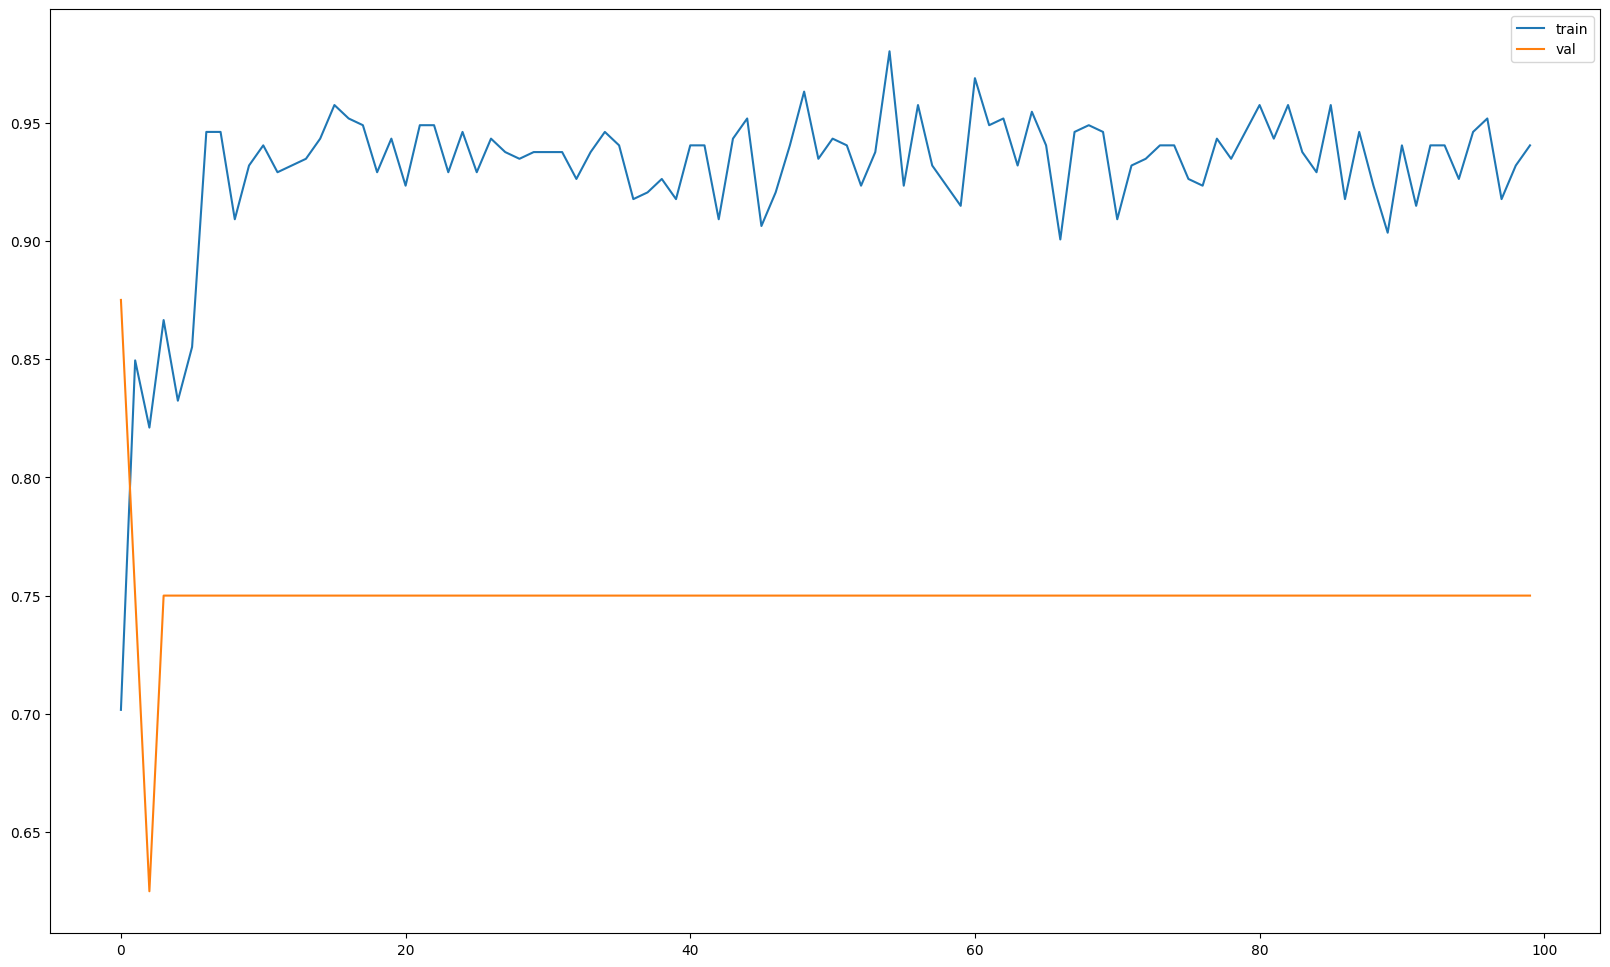

In [17]:
print(max(accuracy_history_train))
print(max(accuracy_history_val))
plt.figure(figsize=(20,12))
plt.plot(epoch_history ,accuracy_history_train,label = 'train')
plt.plot(epoch_history ,accuracy_history_val,label = 'val')
plt.legend()
plt.show()

In [28]:
test_dir = 'test'
shutil.copytree(os.path.join(data_root, 'test'), os.path.join(test_dir, 'unknown'))

class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path
    
val_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
test_dataset = ImageFolderWithPaths('/kaggle/working/test', val_transforms)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [18]:
model.load_state_dict(torch.load('best_model.pt'))

<All keys matched successfully>

In [19]:
model.eval()

val_predictions = []
val_img_paths = []
for inputs, labels in tqdm(val_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs).argmax(dim=1)
    val_predictions.append(preds)
        #orch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
    #val_img_paths.extend(paths)
    
#val_predictions = np.concatenate(val_predictions)

100%|██████████| 1/1 [00:00<00:00,  2.63it/s]


In [20]:
val_predictions = torch.cat(val_predictions)

In [22]:
preds = model("/kaggle/working/val/dirty/0009.jpg").argmax(dim=1)

TypeError: conv2d() received an invalid combination of arguments - got (str, Parameter, NoneType, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, tuple of ints padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!str!, !Parameter!, !NoneType!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, int)
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, str padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!str!, !Parameter!, !NoneType!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, int)


In [33]:
for inputs, labels in tqdm(val_dataloader):
    #plt.imshow(inputs)
    #show_input(input_tensor, title='')
#     show_input(inputs[0,:,:,:])
#     show_input(inputs[1,:,:,:])
#     show_input(inputs[2,:,:,:])
#     show_input(inputs[3,:,:,:])
#     show_input(inputs[4,:,:,:])
#     show_input(inputs[5,:,:,:])
#     show_input(inputs[6,:,:,:])
#     show_input(inputs[7,:,:,:])
    print((labels==val_predictions.cpu()).float().mean())
    break

  0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.8750)


In [34]:
model.eval()

test_predictions = []
test_img_paths = []
for inputs, labels, paths in tqdm(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
    test_predictions.append(
        torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
    test_img_paths.extend(paths)
    
test_predictions = np.concatenate(test_predictions)

100%|██████████| 93/93 [00:06<00:00, 14.03it/s]


In [35]:
submission_df = pd.DataFrame.from_dict({'id': test_img_paths, 'label': test_predictions})

In [36]:
submission_df['label'] = submission_df['label'].map(lambda pred: 'dirty' if pred > 0.5 else 'cleaned')
submission_df['id'] = submission_df['id'].str.replace('/kaggle/working/test/unknown/', '')
submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
submission_df.set_index('id', inplace=True)
submission_df.head(n=6)

,label
id,
0000,dirty
0001,dirty
0002,dirty
0003,dirty
0004,dirty
0005,dirty


In [37]:
submission_df.to_csv("submission.csv")

In [38]:
#!rm -rf train val test